In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

유튜버 신박Ai님 영상 실습

### 모델 구축
Fc layer, activation = tanh 반복

In [15]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28,128),
            nn.Tanh(),
            nn.Linear(128,64),
            nn.Tanh(),
            nn.Linear(64,12),
            nn.Tanh(),
            nn.Linear(12,3)
        )
        #decoder
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.Tanh(),
            nn.Linear(12,64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
    def forward(self, x):
        #x_encoded는 잠재 공간에 대한 행렬
        x_encoded = self.encoder(x)
        x = self.decoder(x_encoded)
        return x, x_encoded
#encoder와 decoder는 완벽히 대칭임
#잠재 공간의 차원이 높을 수로 복원률이 높음

#### 데이터 로딩

In [30]:
transform = transforms.Compose([
    #pytorch tensor로 변환
    transforms.ToTensor(),
])
#학습 데이터 로드
train_Dataset = datasets.MNIST(root='./data',train=True,download=True,transform=transform)
train_loader = DataLoader(train_Dataset, batch_size=32, shuffle = True)
#테스트 데이터 로드
test_Dataset = datasets.MNIST(root='./data',train=False,download=True,transform=transform)
test_loader = DataLoader(test_Dataset, batch_size=1000, shuffle = True)

#### 모델 초기화, 손실함수, 옵티마이저

In [31]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### train

In [32]:
print("Training Start")
num_epoch = 20
for epoch in range(num_epoch):
    for data in train_loader:
        img,_ = data
        #1차원 행렬로 변경, 실제로는 배치가 32라서 (32,784)
        img = img.view(img.size(0), -1)
        output, _ = model(img)
        loss = criterion(output, img)
        
        #기울기 초기화
        optimizer.zero_grad()
        #역전파
        loss.backward()
        optimizer.step()
    print(f"epoch[{epoch+1}/{num_epoch}], loss: {loss.item():.4f}")
print("Training Complete")

Training Start
epoch[1/20], loss: 0.0596
epoch[2/20], loss: 0.0501
epoch[3/20], loss: 0.0477
epoch[4/20], loss: 0.0510
epoch[5/20], loss: 0.0450
epoch[6/20], loss: 0.0461
epoch[7/20], loss: 0.0467
epoch[8/20], loss: 0.0508
epoch[9/20], loss: 0.0422
epoch[10/20], loss: 0.0457
epoch[11/20], loss: 0.0417
epoch[12/20], loss: 0.0440
epoch[13/20], loss: 0.0517
epoch[14/20], loss: 0.0336
epoch[15/20], loss: 0.0388
epoch[16/20], loss: 0.0438
epoch[17/20], loss: 0.0422
epoch[18/20], loss: 0.0387
epoch[19/20], loss: 0.0387
epoch[20/20], loss: 0.0345
Training Complete


### test

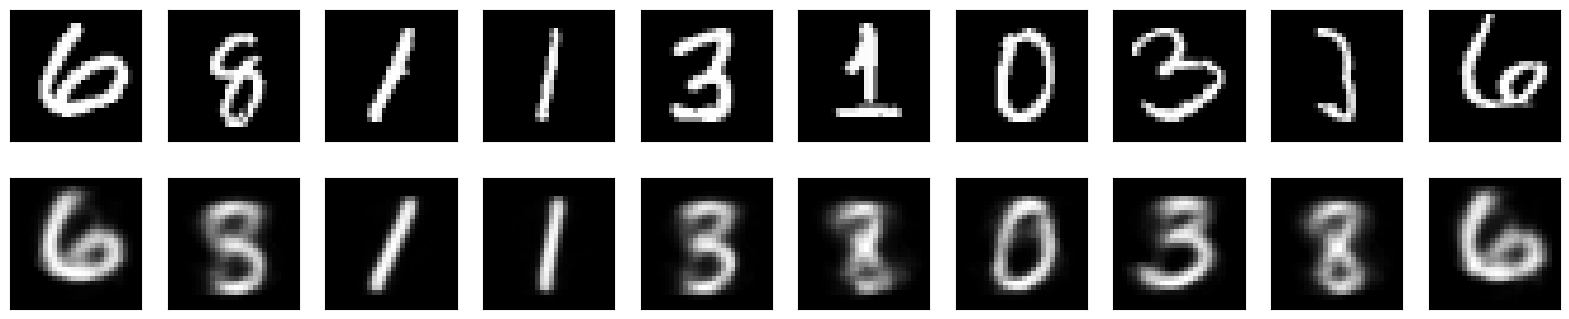

In [35]:
dataiter = iter(test_loader)
images, _ = next(dataiter)
images_flattened = images.view(images.size(0), -1)

output, _ = model(images_flattened)
#실제 이미지형태로 다시 변환
output = output.view(output.size(0),1, 28, 28).detach()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.squeeze().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

### 잠재 공간 분포

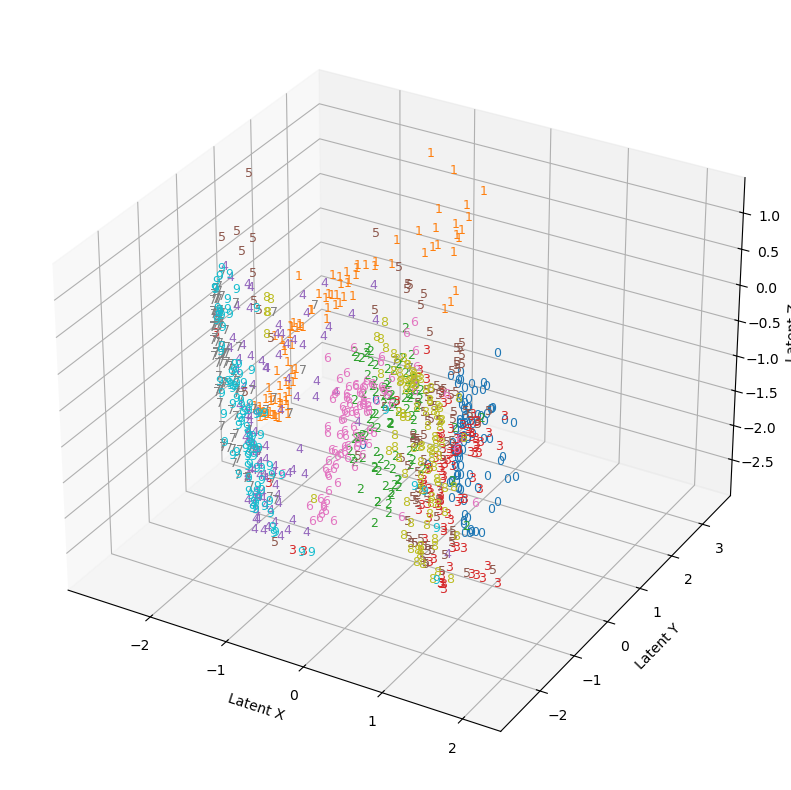

In [34]:
model.eval()

latent_vectors=[]
labels=[]

with torch.no_grad():
    for data in test_loader:
        imgs, lbls = data
        imgs = imgs.view(imgs.size(0), -1)
        _, latents = model(imgs)
        latent_vectors.append(latents)
        labels.append(lbls)
latent_vectors = torch.cat(latent_vectors, dim=0)
labels = torch.cat(labels, dim=0)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(10):
    indices = np.where(labels == i)[0]
    subset_indices = np.random.choice(indices, size=min(len(indices),100), replace=False)
    
    for idx in subset_indices:
        ax.text(latent_vectors[idx, 0].item(), latent_vectors[idx,1].item(), latent_vectors[idx,2].item(),
               str(i),color = plt.cm.tab10(i), fontsize = 9, ha='center')
        
x_min, x_max = latent_vectors[:,0].min(),latent_vectors[:,0].max()
y_min, y_max = latent_vectors[:,1].min(),latent_vectors[:,1].max()
z_min, z_max = latent_vectors[:,2].min(),latent_vectors[:,2].max()
    
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

ax.set_xlabel('Latent X')
ax.set_ylabel('Latent Y')
ax.set_zlabel('Latent Z')

plt.show()